[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fweberling/epistasis/blob/main/Epistasis_analysis.ipynb)






In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
from analysis_utils import preprocessing, double_mut_pos, epistasis_graph, epistatic_triangles, comb_pos_mut, construct_structural_epistasis_graph
from plotting_utils import plot_node_degree_distribution, plot_node_degree_aa_distribution, \
    plot_mutation_distribution, plot_epistasis_model, plot_obs_fitness_heatmap
import numpy as np
import itertools
import scipy as sp

# Combinability and epistasis analysis

This notebook showcases the analyses for combinability and epistasis. These analyses are the foundation of plots in Figure 3 and S8 of the paper.

## Wildtype Sequence

Define the wildtype sequence of the IRED

In [2]:
# Specify sequence of reference protein
reference = "MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQGAVLASSARDAAEASPLVVVCVSDHAAVRAVLDPLGDVLAGRVLVNLTSGTSEQARATAEWAAERGITYLDGAIMAIPQVVGTADAFLLYSGPEAAYEAHEPTLRSLGAGTTYLGADHGLSSLYDVALLGIMWGTLNSFLHGAALLGTAKVEATTFAPFANRWIEAVTGFVSAYAGQVDQGAYPALDATIDTHVATVDHLIHESEAAGVNTELPRLVRTLADRALAGGQGGLGYAAMIEQFRSPS*"

## Data Pre-Processing

This is is the pre-processing of the IRED DMS data for the combinability and epistasis analysis. To run the pre-processing, the data containing .csv file must be loaded into a pandas dataframe.



In [3]:
# Upload input files into panda data frame
PATH = "srired_active_data.csv"
data_frame = pd.read_csv(PATH)

For the pre-processing, the maximum order of mutations to be analysed (e.g. double, triple, quadruple etc.) must be defined\


In [4]:
# Specify maximum order of mutations to be analysed i.e. mutations up to that order will be analysed
num_mut = 5

Then, the pre-processing pipeline can be run. The number of variants belonging to a certain order of mutations are printed.

In [5]:
# Preprocess the data
preprocessed_data = preprocessing(data_frame, num_mut, reference)

# Lists of sequences, observed and expected fitness scores, and epistatic scores for each mutation order (e.g. 2,3,4,5)
for i in range(2, num_mut + 1):
    locals()["mut_" + str(i) + "_sequence_list"] = preprocessed_data[str(i) + " Mutation"]["Sequence of mutants"]
    locals()["mut_" + str(i) + "_W_observed_list"] = preprocessed_data[str(i) + " Mutation"]["Observed fitness"]
    locals()["mut_" + str(i) + "_W_observed_std_list"] = preprocessed_data[str(i) + " Mutation"]["Observed std of " \
                                                                                                 "fitness"]
    locals()["mut_" + str(i) + "_W_expected_list"] = preprocessed_data[str(i) + " Mutation"]["Expected fitness"]
    locals()["mut_" + str(i) + "_W_expected_std_list"] = preprocessed_data[str(i) + " Mutation"]["Expected std of " \
                                                                                                 "fitness"]
    locals()["mut_" + str(i) + "_epistatic_score_list"] = preprocessed_data[str(i) + " Mutation"]["Epistatic score"]

# Lists of sequences, observed and expected fitness scores, and epistatic scores for all mutation orders i.e. 2 - 5
full_mut_sequence_list = []
full_mut_W_observed_list = []
full_mut_W_observed_std_list = []
full_mut_W_expected_list = []
full_mut_W_expected_std_list = []
full_mut_epistatic_score_list = []

for mut_num_i in range(2, num_mut + 1):
    full_mut_sequence_list = full_mut_sequence_list + locals()["mut_" + str(mut_num_i) + "_sequence_list"]
    full_mut_W_observed_list = full_mut_W_observed_list + locals()["mut_" + str(mut_num_i) + "_W_observed_list"]
    full_mut_W_observed_std_list = full_mut_W_observed_std_list + locals()[
        "mut_" + str(mut_num_i) + "_W_observed_std_list"]
    full_mut_W_expected_list = full_mut_W_expected_list + locals()["mut_" + str(mut_num_i) + "_W_expected_list"]
    full_mut_W_expected_std_list = full_mut_W_expected_std_list + locals()[
        "mut_" + str(mut_num_i) + "_W_expected_std_list"]
    full_mut_epistatic_score_list = full_mut_epistatic_score_list + locals()[
        "mut_" + str(mut_num_i) + "_epistatic_score_list"]


number of variants with mutations of order 1 analyzed: 1253
number of variants with mutations of order 2 analyzed: 3421
number of variants with mutations of order 3 analyzed: 2331
number of variants with mutations of order 4 analyzed: 1374
number of variants with mutations of order 5 analyzed: 702


## Epistasis model

The epistasis model is created for the order of mutations that has been selected. Here, the model is plotted for mutations of order 2 to 5. The pearson correlation coefficient is printed as well.

correlation calculated double mutations fitness / double mutation fitness: pearson r = 0.29861079231090654 with p = 1.181410691860569e-127


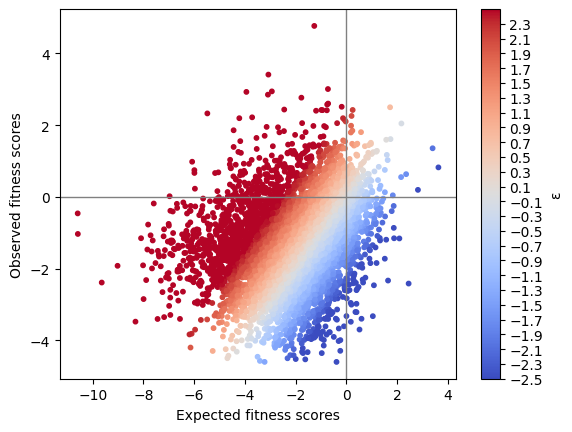

In [6]:
# Plot epistasis model for mutations 2 - 5
r_d_s, p_d_s = sp.stats.pearsonr(full_mut_W_expected_list, full_mut_W_observed_list)
print(f"correlation calculated double mutations fitness / double mutation fitness: pearson r = {r_d_s} with p = {p_d_s}")
plot_epistasis_model(full_mut_W_expected_list, full_mut_W_observed_list, full_mut_epistatic_score_list)


A Heatmap showing pairwise combinatorial fitness effects convoluted from data from variants with mutations of order 2 to 5. The $x$ and $y$ axis display the mutated amino acid positions.

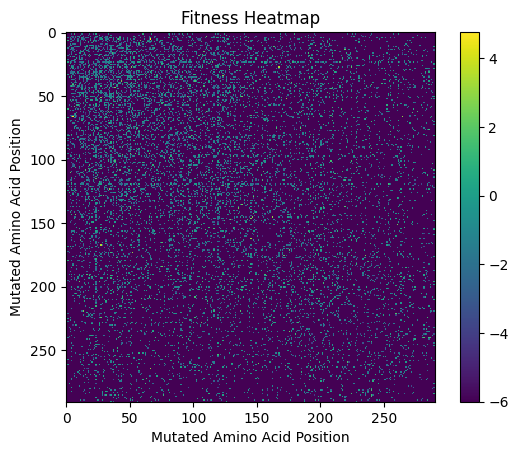

In [7]:
# Fitness Heatmap
plot_obs_fitness_heatmap(reference, full_mut_sequence_list, full_mut_W_observed_list)

## Combinability graph with $k_{obs} = 1$ and $k_{exp} = -1$

Given the user defined multiples $k_{obs}$ of the standard deviation of observed fitness $\sigma_{obs}$ and $k_{exp}$ of the expected fitness $\sigma_{exp}$, a list of at residue positions is created which are at least double mutations. Here, $k_{obs} = 1$ and $k_{exp} = -1$ are chosen such that combinable mutations are analysed.


In [8]:
# Multiples of standard deviation for observed and expected fitness
k_obs = 1
k_exp = -1

# List of all positive / combinable mutations
comb_pos_mut_pos_list, comb_pos_mut_aa_list = comb_pos_mut(full_mut_epistatic_score_list, full_mut_W_observed_list,
                                                           full_mut_W_expected_list, full_mut_W_observed_std_list,
                                                           full_mut_sequence_list, reference, k_obs, k_exp)

This list of is then used to construct a combinability graph $\mathcal{G}=(V,E)$ where the set of nodes $V$ are residue positions and the set of edges $E$ display the combinability of two residue positions.



In [9]:
# Unpack list of into pairs
pos_comb_mut_edges = []
pos_comb_mut_aa = []
for higher_ord_mut in range(0, len(comb_pos_mut_pos_list)):
    higher_order_mut_list = (list(map(list, itertools.combinations(comb_pos_mut_pos_list[higher_ord_mut], 2))))
    higher_order_mut_aa_list = (list(map(list, itertools.combinations(comb_pos_mut_aa_list[higher_ord_mut], 2))))
    if len(higher_order_mut_list) == 2:
        pos_comb_mut_edges.append(higher_order_mut_list)
        pos_comb_mut_aa.append(higher_order_mut_aa_list)
    else:
        for higher_order_mut_list_ele in range(0, len(higher_order_mut_list)):
            pos_comb_mut_edges.append(higher_order_mut_list[higher_order_mut_list_ele])
            pos_comb_mut_aa.append(higher_order_mut_aa_list[higher_order_mut_list_ele])


The node degree distribution of the combinability graph is plotted along the residue positions. The contribution of each amino acid type is coloured. This plot corresponds to Figure S8 D and is the foundation of Figure 3 C.

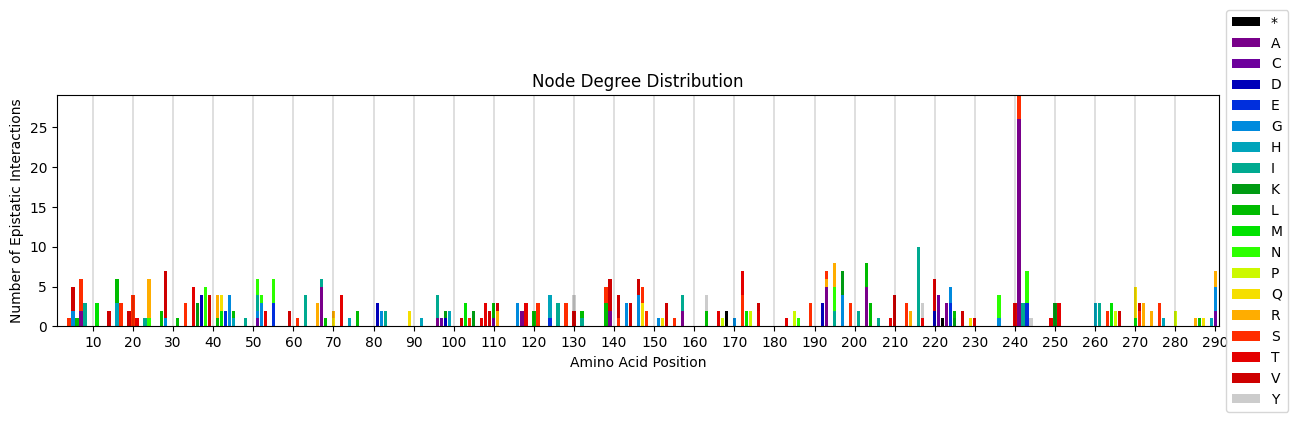

In [10]:
# Node degree and amino acid distribution
pos_comb_higher_mut_pos = np.concatenate(
    (np.array(pos_comb_mut_edges)[:, 0], np.array(pos_comb_mut_edges)[:, 1].astype(int)), axis=0)
pos_comb_higher_mut_mut_aa = np.concatenate((np.array(pos_comb_mut_aa)[:, 0], np.array(pos_comb_mut_aa)[:, 1]), axis=0)

pos_comb_higher_mut_pos_aa = np.stack((pos_comb_higher_mut_pos, pos_comb_higher_mut_mut_aa), axis=1)

pos_per_aa_dict = plot_node_degree_aa_distribution(pos_comb_higher_mut_pos_aa)


For the combinability graph $\mathcal{G}={V, E}$, the position of the nodes is inferred from a distance matrix that stores the minimal distances of residues of the IRED dimer. This distance matrix reduced to two dimensions via principal component analysis. These two dimensions are then used as coordinates of the nodes of the combinability graph. Thus, a node's position represents how close a residue position is to all others. The plot corresponds to Figure S8 B and is the foundation of Figure 3 D.

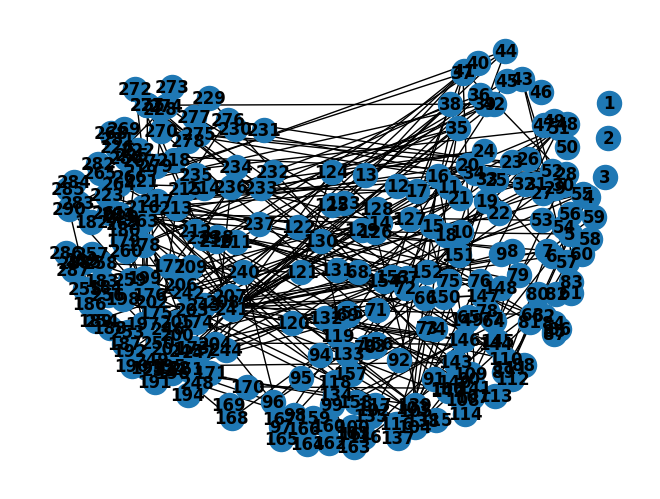

In [11]:
# Load distance matrix
dist_matrix = np.load("min_dimer_distances.npy")

# Minimal number of counts for an amino acid position to be included in the graph
minimal_count_per_node = 0

# Combinability graph for all mutants 2 - 5
structural_epistasis_graph = construct_structural_epistasis_graph(pos_comb_mut_edges, minimal_count_per_node, dist_matrix)
pos = nx.get_node_attributes(structural_epistasis_graph, 'pos')

plt.figure()
nx.draw(structural_epistasis_graph, pos, with_labels=True, font_weight='bold')
plt.show()

Given the graph, a csv file is created that contains the list of edges that are the foundation for the plot in Figure 3 D.

In [12]:
graph_edges_list = list(structural_epistasis_graph.edges)

# Create a list of column names
col_names = ["AA Residue 1", "AA Residue 2"]

# Create a pandas dataframe from the list of tuples
df = pd.DataFrame(graph_edges_list, columns=col_names)

df.to_csv('graph_edges_list_1_-1.csv')


## Epistasis graph with $k_{obs} = 1$ and $k_{exp} = 1$

Given the user defined multiples $k_{obs}$ of the standard deviation of observed fitness $\sigma_{obs}$ and $k_{exp}$ of the expected fitness $\sigma_{exp}$, a list of at residue positions is created which are at least double mutations. Here, $k_{obs} = 1$ and $k_{exp} = 1$ are chosen such that positively epistatic, combinable mutations are analysed.

In [13]:
# Multiples of standard deviation for observed and expected fitness
k_obs = 1
k_exp = 1

# List of all positive / combinable mutations
comb_pos_mut_pos_list, comb_pos_mut_aa_list = comb_pos_mut(full_mut_epistatic_score_list, full_mut_W_observed_list,
                                                           full_mut_W_expected_list, full_mut_W_observed_std_list,
                                                           full_mut_sequence_list, reference, k_obs, k_exp)

This list of is then used to construct an epistasis graph $\mathcal{G}=(V,E)$ where the set of nodes $V$ are residue positions and the set of edges $E$ display the positive epistatic interaction of two residue positions.

In [14]:
# Unpack list of into pairs
pos_comb_mut_edges = []
pos_comb_mut_aa = []
for higher_ord_mut in range(0, len(comb_pos_mut_pos_list)):
    higher_order_mut_list = (list(map(list, itertools.combinations(comb_pos_mut_pos_list[higher_ord_mut], 2))))
    higher_order_mut_aa_list = (list(map(list, itertools.combinations(comb_pos_mut_aa_list[higher_ord_mut], 2))))
    if len(higher_order_mut_list) == 2:
        pos_comb_mut_edges.append(higher_order_mut_list)
        pos_comb_mut_aa.append(higher_order_mut_aa_list)
    else:
        for higher_order_mut_list_ele in range(0, len(higher_order_mut_list)):
            pos_comb_mut_edges.append(higher_order_mut_list[higher_order_mut_list_ele])
            pos_comb_mut_aa.append(higher_order_mut_aa_list[higher_order_mut_list_ele])

The node degree distribution of the combinability graph is plotted along the residue positions. The contribution of each amino acid type is coloured. This plot corresponds to Figure S8 E.

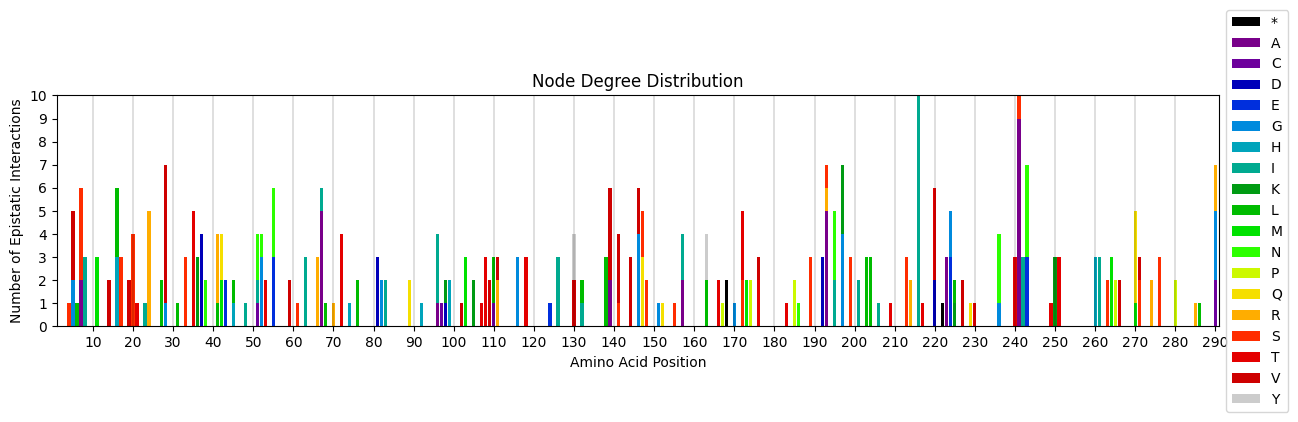

In [15]:
# Node degree and amino acid distribution
pos_comb_higher_mut_pos = np.concatenate(
    (np.array(pos_comb_mut_edges)[:, 0], np.array(pos_comb_mut_edges)[:, 1].astype(int)), axis=0)
pos_comb_higher_mut_mut_aa = np.concatenate((np.array(pos_comb_mut_aa)[:, 0], np.array(pos_comb_mut_aa)[:, 1]), axis=0)

pos_comb_higher_mut_pos_aa = np.stack((pos_comb_higher_mut_pos, pos_comb_higher_mut_mut_aa), axis=1)

pos_per_aa_dict = plot_node_degree_aa_distribution(pos_comb_higher_mut_pos_aa)


For the epistasis graph $\mathcal{G}={V, E}$, the position of the nodes is inferred from a distance matrix that stores the minimal distances of residues of the IRED dimer. This distance matrix reduced to two dimensions via principal component analysis. These two dimensions are then used as coordinates of the nodes of the combinability graph. Thus, a node's position represents how close a residue position is to all others. The plot corresponds to Figure S8 C and is the foundation of Figure 3 E (for that `minimal_count_per_node = 5` to filter out nodes with less than 5 edges).

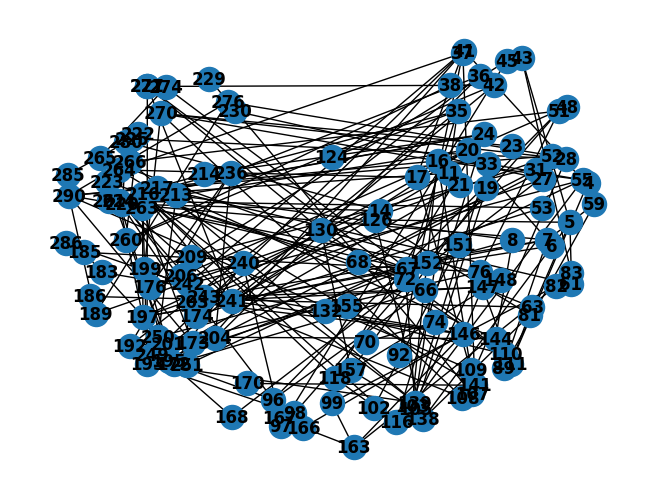

In [16]:
# Load distance matrix
dist_matrix = np.load("min_dimer_distances.npy")

# Minimal number of counts for an amino acid position to be included in the graph
minimal_count_per_node = 0

# Combinability graph for all mutants 2 - 5
structural_epistasis_graph = construct_structural_epistasis_graph(pos_comb_mut_edges, minimal_count_per_node, dist_matrix, zero_edge_nodes=False)
pos = nx.get_node_attributes(structural_epistasis_graph, 'pos')

plt.figure()
nx.draw(structural_epistasis_graph, pos, with_labels=True, font_weight='bold')
plt.show()

Given the graph created using `minimal_count_per_node = 5`, a csv file is created that contains the list of edges that are the foundation for the plot in Figure 3 E.

In [17]:
graph_edges_list = list(structural_epistasis_graph.edges)

# Create a list of column names
col_names = ["AA Residue 1", "AA Residue 2"]

# Create a pandas dataframe from the list of tuples
df = pd.DataFrame(graph_edges_list, columns=col_names)

df.to_csv('graph_edges_list_1_1.csv')